In [41]:
import numpy as np
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from Landscapes import *
import pandas as pd

In [270]:
def create_dotSpace(N=10,hypers=[1,1,1,1,1,1,1,1,1,1],masked=False, mask=None):
    our_dirichlet = stats.dirichlet(hypers)    
    all_permutations = list(itertools.product([0,1],repeat = N))
    fitnesses = []
    perms = []
    transformed_locs = []
    for perm in all_permutations:
        fitnesses.append(np.dot(perm,our_dirichlet.rvs()[0]))
        if masked:
            if mask:
                perm = transform(perm,mask)
            else:
                perm = transform(perm)
        perms.append("".join([str(i) for i in perm]))
        transformed_locs.append(perm)
    frame = {"Fitness":pd.Series(fitnesses,index=perms), "Location":pd.Series(transformed_locs,index=perms)}
    return pd.DataFrame(frame)

def transform(location, mask=[1,0,1,0,0,0,1,1,1,0]):
    assert len(location) == len(mask), "The mask needs to be same length as the location"
    
    return [abs(i-1) if j==1 else i for i,j in zip(location, mask)]

def get_iterated_search_walk(Landscape,Neighbor_Distance,Step_Size,Iterations):
    #initalize random position
    N=len(Landscape.iloc[0].Location)
    Position= Position_rand(N)

    FitnessHistory=[Landscape.loc["".join([str(i) for i in Position])].Fitness]
    #record jumps down
    Jump_Down_history=[1]

    for j in range(Iterations):

        #Identify the Neighbors (distance of M from initial position row)
        Neighbors = Landscape[Landscape['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(Landscape.loc["".join([str(i) for i in Position])].Location)))==Neighbor_Distance)]

        BetterNeighbors = Neighbors[Neighbors.Fitness>Landscape.loc["".join([str(i) for i in Position])].Fitness]
        #randomize order of neighobrs then loop until one exceeds
        if len(BetterNeighbors)>0: #only update if there exists at least one superior neighobr
            BetterNeighbors.sample(frac=1)#randomly sample better neighbors
            Position = BetterNeighbors.index.values[0] #return the first index value
            Jump_Down_history.append(0)

        #take a step of size Step_Size
        else:
            Position = Perturbation(Position,Step_Size)
            Jump_Down_history.append(1)

            #Append to fitness data
        fit = Landscape.loc["".join([str(i) for i in Position])].Fitness
        FitnessHistory.append(fit)
        
    return(FitnessHistory,Jump_Down_history)


    
def Get_Landscape_Summary(df,N):


    ##Record the autocorrelation of a random walk
    FitnessPath = random_walker(1000, df)
    AR = Get_AR(FitnessPath,lag_range=N)

    MaximalLocation = df.iloc[:,0].idxmax() #get the index

    ####Now generate a statistic that finds how close on average, are the 90th percentile and above
    ####fitness to the maximum
    Percentile_90_Cutoff = (df.iloc[:,0].quantile(.90))
    #get those that pass cutoff
    CutoffPassed = df[ df.iloc[:,0]>= Percentile_90_Cutoff]
    Distances = CutoffPassed['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[MaximalLocation].Location))))
    Average_Distance_Percentile_90=Distances.mean()

    ##Now Identify the Number of Maxima
    Number_Maxima = Count_Local_Maxima(df)

    history, jump_history = get_iterated_search_walk(df,1,2,150)
    
    print("Avg distance for 90th percentile to Max\t", Average_Distance_Percentile_90)
    print("Num of Local Maxima\t\t\t",Number_Maxima)
    
    print("Mean fitness",df.Fitness.mean())
    print("S.D. of fitness", df.Fitness.var()**.5)

    f, axarr = plt.subplots(2,2,figsize=(15,10))
    axarr[0,0].set_title("Auto-correlation by step distance",size=14)
    axarr[0,0].plot(AR,color="b")
    axarr[0,1].set_title("Random Walk",size=14)
    axarr[0,1].plot(FitnessPath[:250])
    axarr[1,0].set_title("Iterated Local Search", size=14)
    axarr[1,0].plot((history),'r--o',label='k=1')
    axarr[1,0].plot((jump_history),'*',label='k=1_Jump')
    axarr[1,0].legend()

    axarr[1,1].set_title("Fitness Distribution", size=14)
    axarr[1,1].hist(df["Fitness"])
    
    plt.show()
    
    cmap=plt.cm.get_cmap('coolwarm')
    landscape_as_graph(df,cmap)

    
def landscape_as_graph(df,cmap):

    N=len(df.iloc[0].name)
    hypercube = nx.hypercube_graph(N)

    colors=[]
    fitness_dict = {}
    f_min = df.iloc[:,0].min()
    f_max = df.iloc[:,0].max()
    fractor = 1/(f_max-f_min)
    for row, focal_row in df.iterrows():
        source_fit = fractor*(focal_row.Fitness - f_min)
        fitness_dict[row]= source_fit
        colors.append(cmap(source_fit))

    nx.set_node_attributes(hypercube,fitness_dict, "fitness")

    nx.draw(hypercube, node_color=colors, with_labels=False, node_size=50,width=.25)  




### Some comparisons

Avg distance for 90th percentile to Max	 2.378640776699029
Num of Local Maxima			 6
Mean fitness 0.49910001157140643
S.D. of fitness 0.1654604805887312


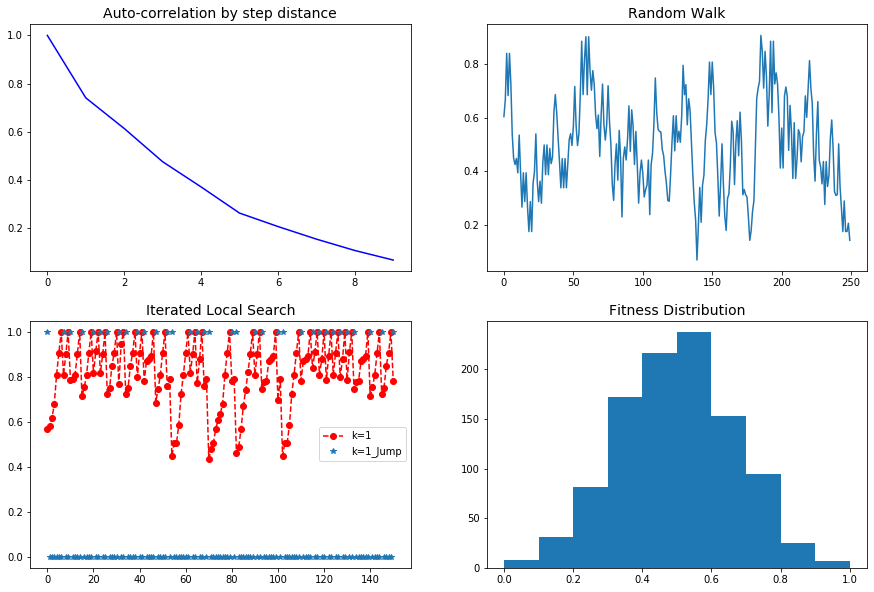

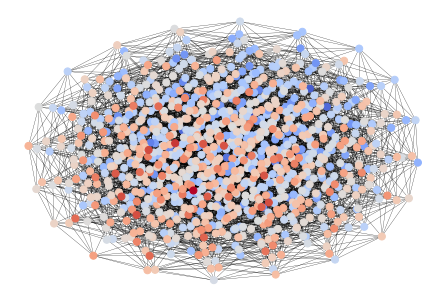

In [271]:
N = 10
hypers = [10,10,10,10,10,10,10,10,10,10]

Get_Landscape_Summary(create_dotSpace(N,hypers),N)

Avg distance for 90th percentile to Max	 2.9223300970873787
Num of Local Maxima			 51
Mean fitness 0.4973679967593796
S.D. of fitness 0.21105352483547715


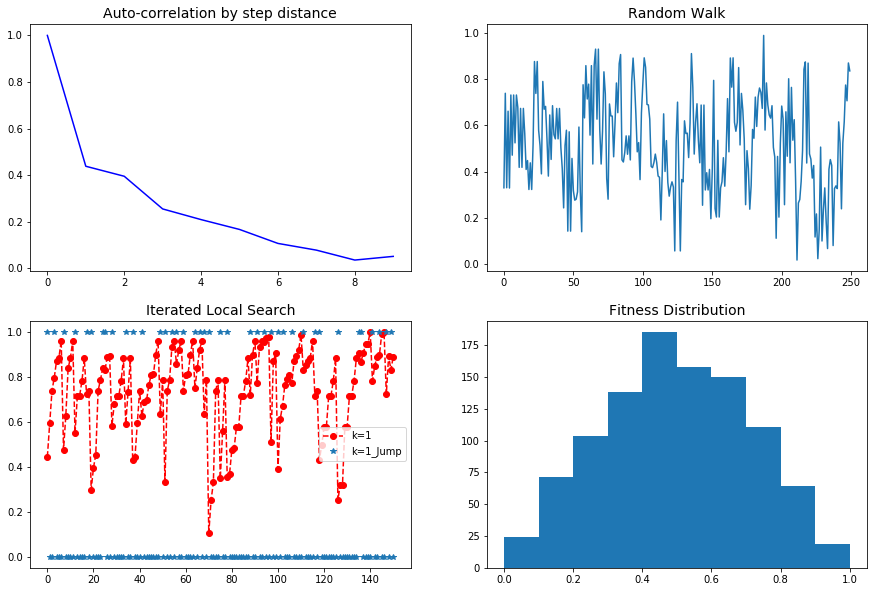

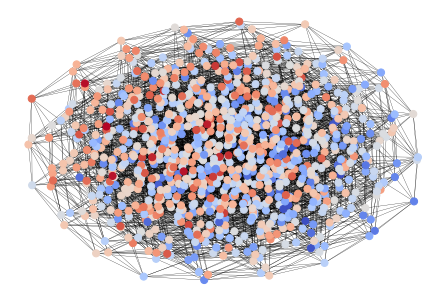

In [272]:
N = 10
hypers = [1,1,1,1,2,1,1,1,1,1]
Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.825242718446602
Num of Local Maxima			 1
Mean fitness 0.5508096158082213
S.D. of fitness 0.06394382294726897


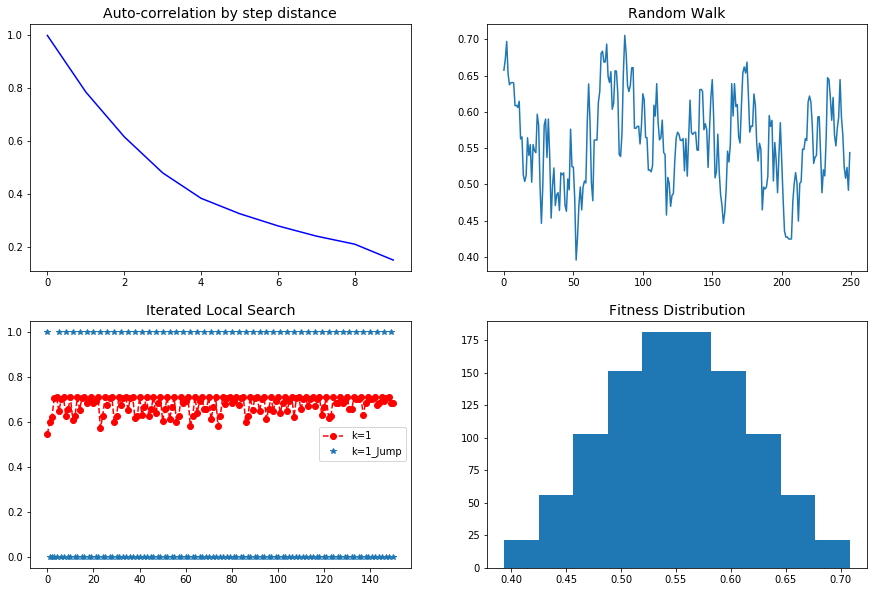

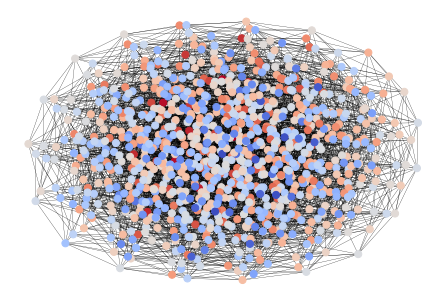

In [255]:
N=10
K=0
Get_Landscape_Summary(make_NK_land(N,K),N)

Avg distance for 90th percentile to Max	 4.980582524271845
Num of Local Maxima			 79
Mean fitness 0.5091367410558321
S.D. of fitness 0.09199817128370918


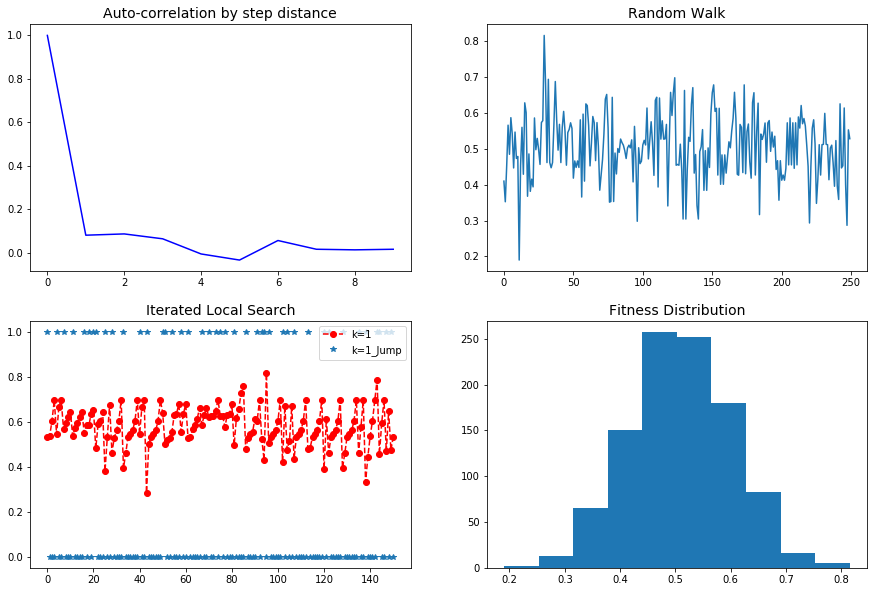

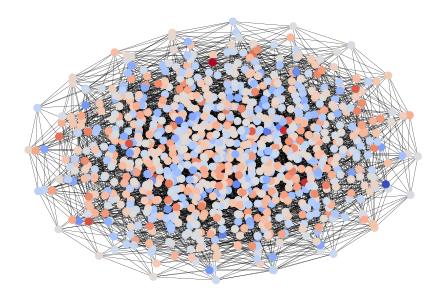

In [256]:
N=10
K=8
Get_Landscape_Summary(make_NK_land(N,K),N)

Avg distance for 90th percentile to Max	 3.7766990291262137
Num of Local Maxima			 69
Mean fitness 0.5026805491403195
S.D. of fitness 0.3666629962549046


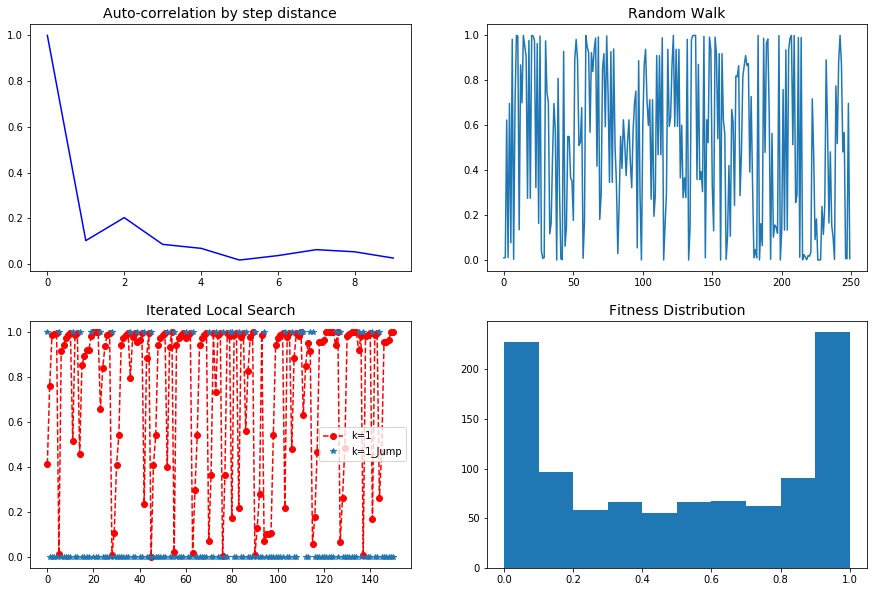

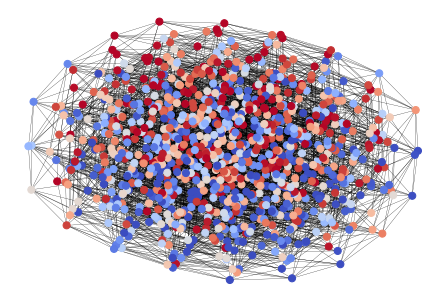

In [274]:
N = 10
hypers = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
Get_Landscape_Summary(create_dotSpace(N,hypers),N)

Avg distance for 90th percentile to Max	 2.679611650485437
Num of Local Maxima			 42
Mean fitness 0.499337550832327
S.D. of fitness 0.19008347386558752


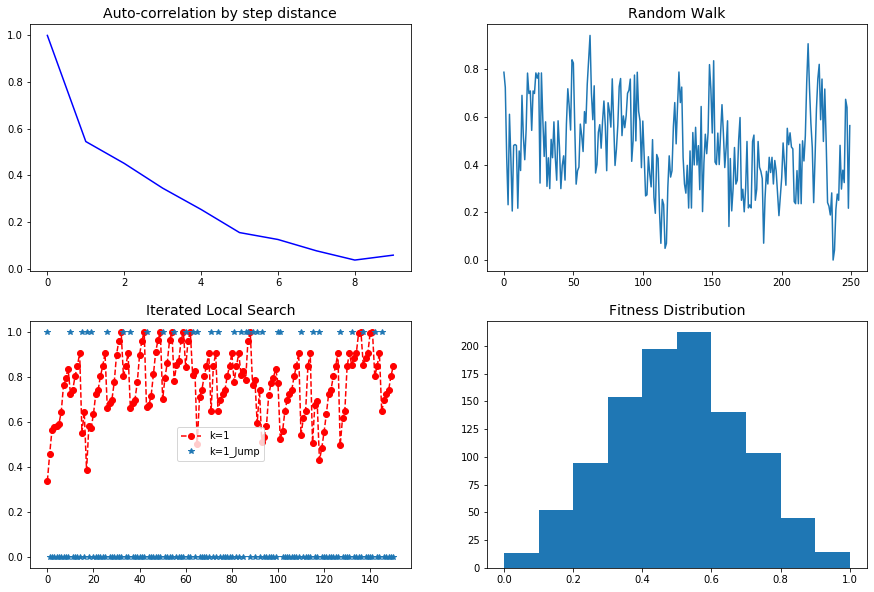

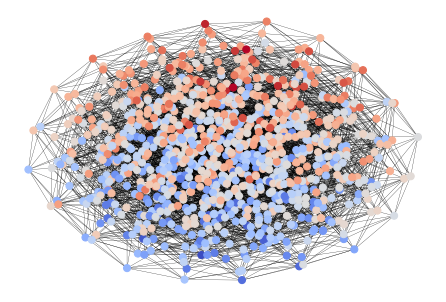

In [275]:
N = 10
hypers = [2,2,2,2,2,2,2,2,2,2]

Get_Landscape_Summary(create_dotSpace(N,hypers),N)

Avg distance for 90th percentile to Max	 2.796116504854369
Num of Local Maxima			 31
Mean fitness 0.5026964991881449
S.D. of fitness 0.18995834705310918


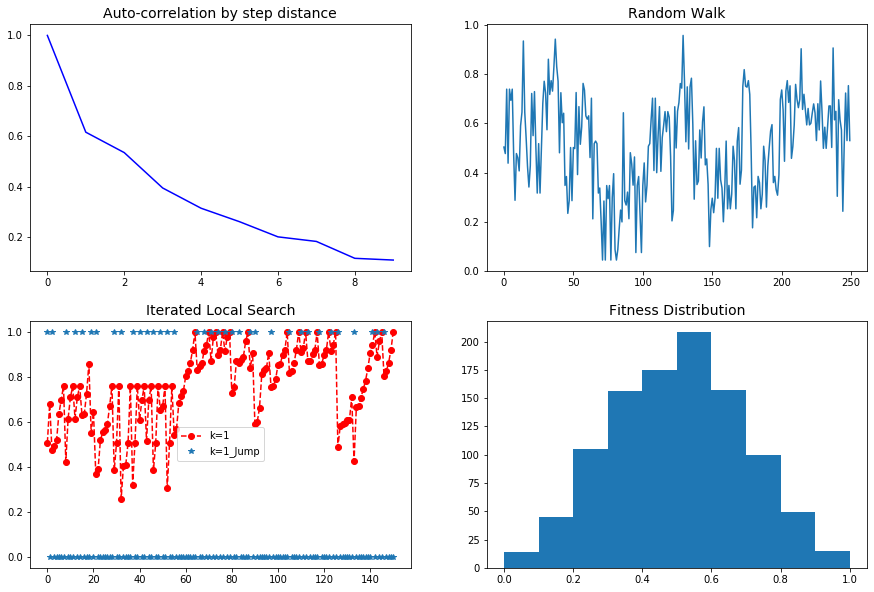

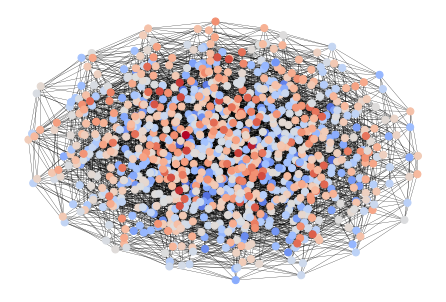

In [277]:
N = 10
hypers = [4,2,2,2,2,2,2,2,2,2]

Get_Landscape_Summary(create_dotSpace(N,hypers),N)

Avg distance for 90th percentile to Max	 2.407766990291262
Num of Local Maxima			 7
Mean fitness 0.5004292758826471
S.D. of fitness 0.17356144136062698


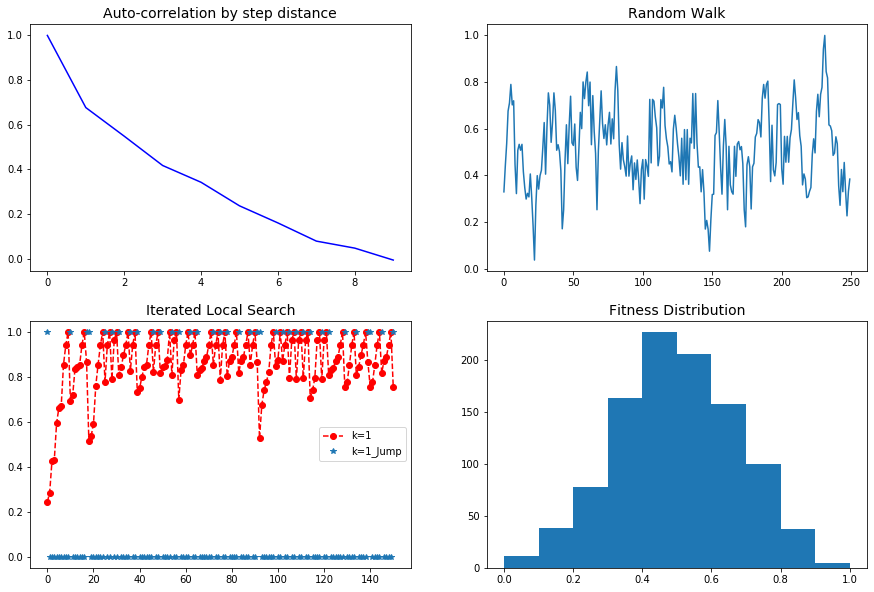

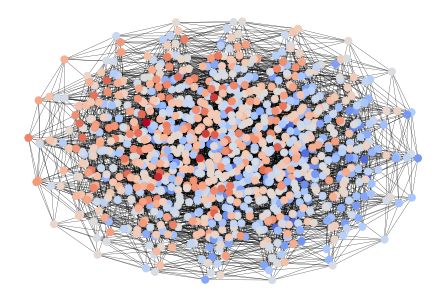

In [290]:
N = 10
hypers = [5,5,6,5,5,5,5,5,5,5]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.4757281553398056
Num of Local Maxima			 12
Mean fitness 0.5031350300416767
S.D. of fitness 0.1712576027846285


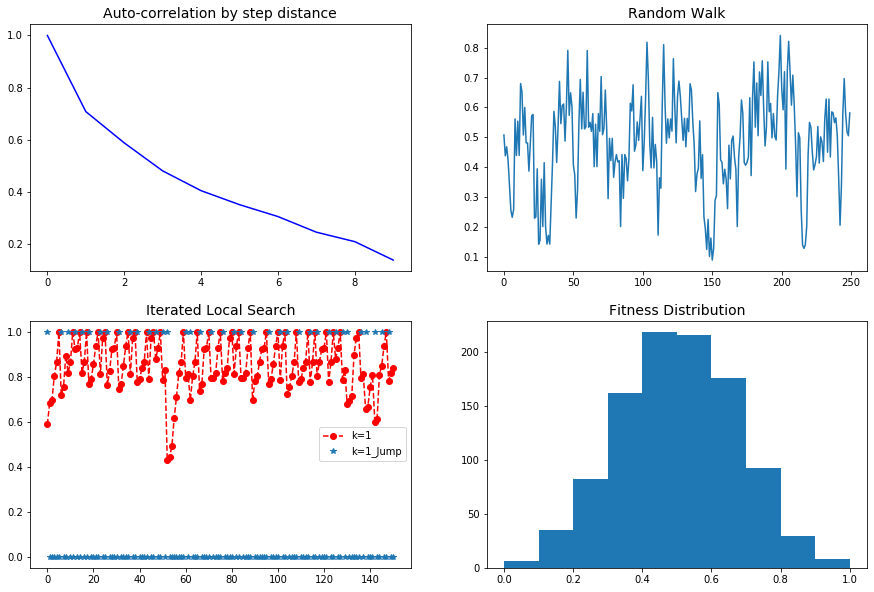

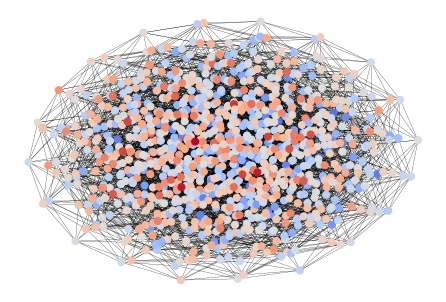

In [289]:
N = 10
hypers = [6,5,6,5,6,5,6,5,6,5]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 3.3398058252427183
Num of Local Maxima			 75
Mean fitness 0.5105883568513742
S.D. of fitness 0.2497613977997244


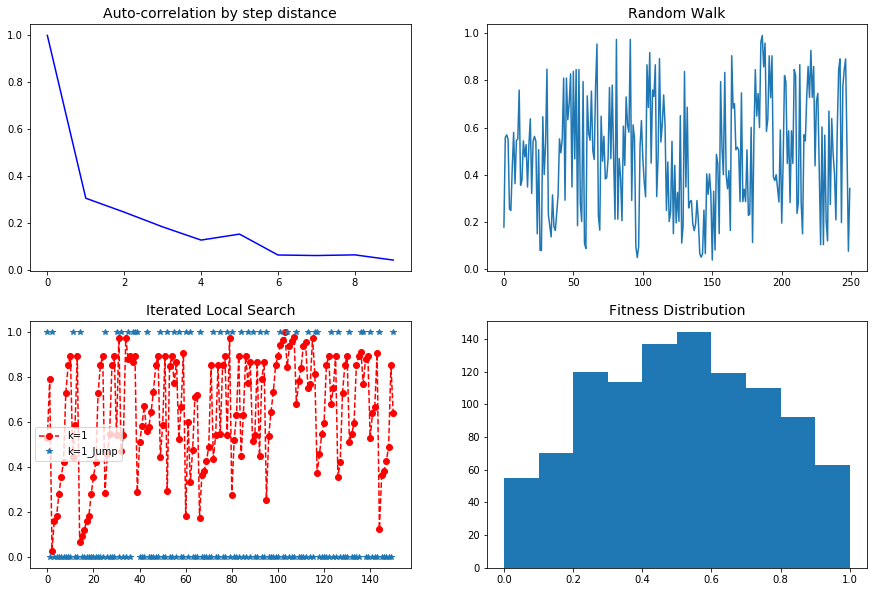

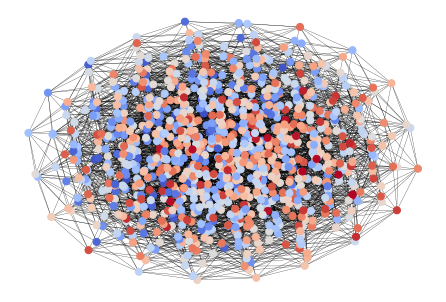

In [286]:
N = 10
hypers = [.50,.50,.50,.50,.50,.50,.50,.50,.50,.50]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.3398058252427183
Num of Local Maxima			 1
Mean fitness 0.49984140845651504
S.D. of fitness 0.1579443291653237


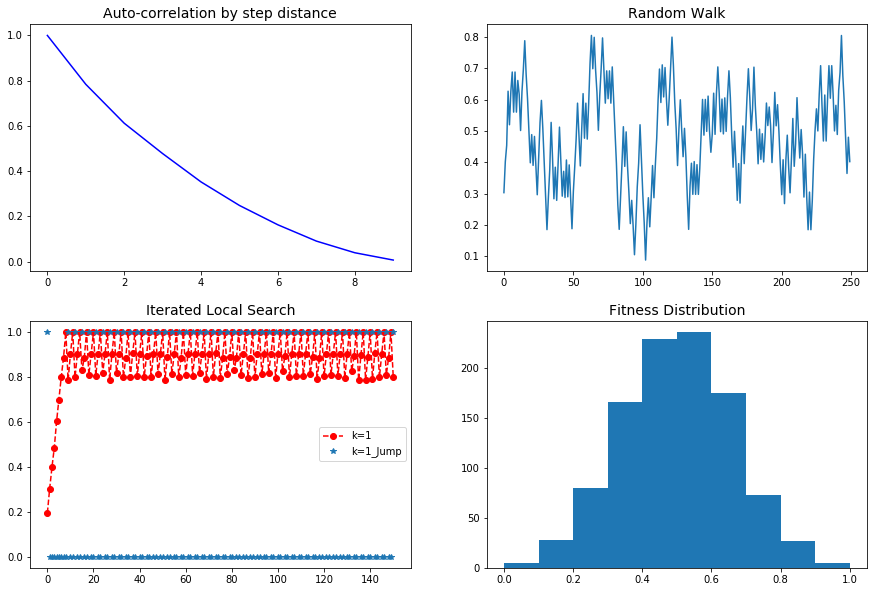

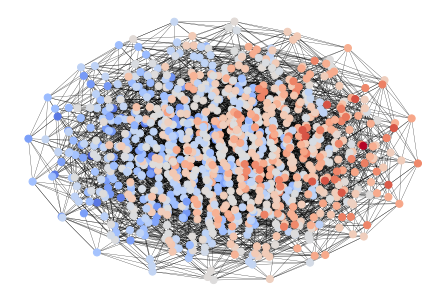

In [276]:
N = 10
hypers = [100,100,100,100,100,100,100,100,100,100]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.9514563106796117
Num of Local Maxima			 38
Mean fitness 0.49805511930080393
S.D. of fitness 0.23606247050607002


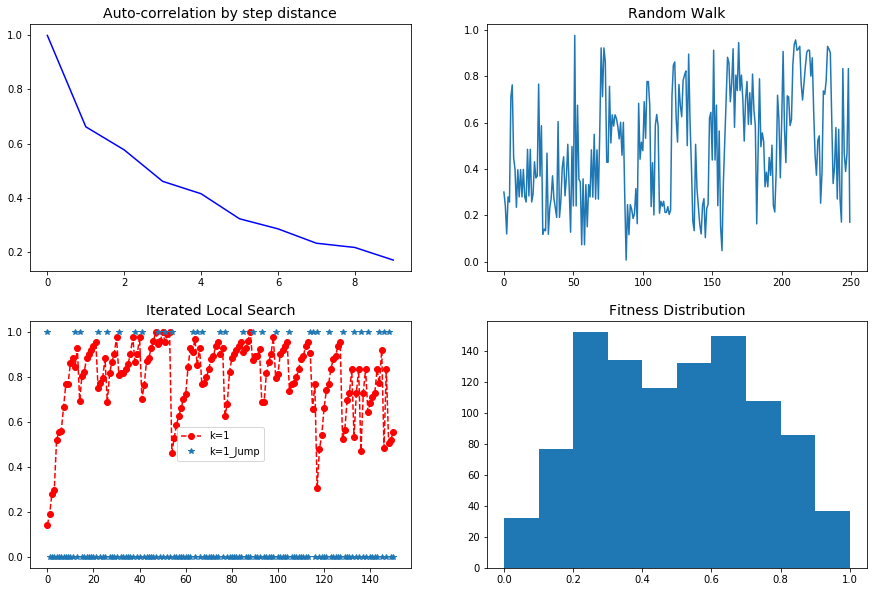

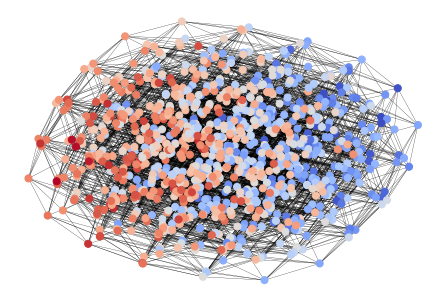

In [279]:
N = 10
hypers = [5,1,1,1,1,1,1,1,1,1]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.9223300970873787
Num of Local Maxima			 19
Mean fitness 0.5059339484556211
S.D. of fitness 0.21083252662034055


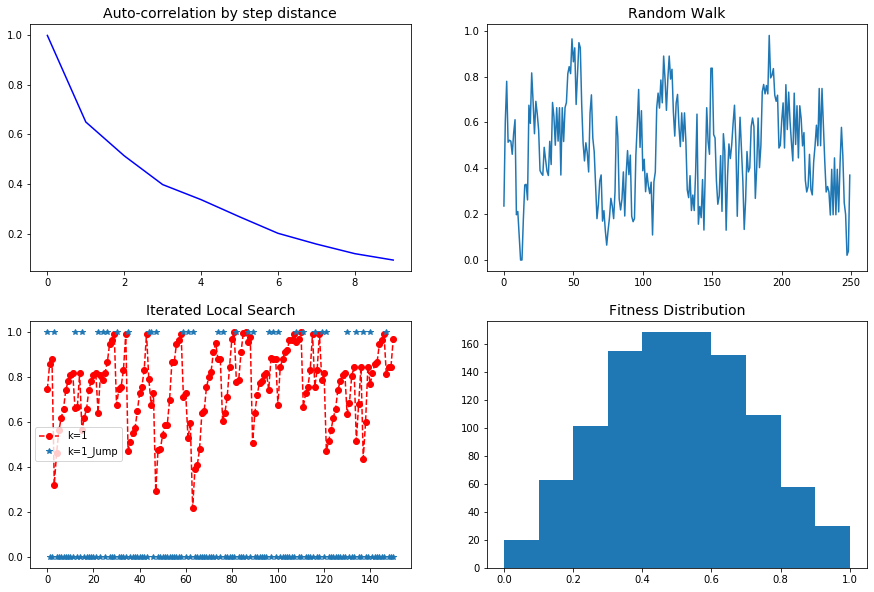

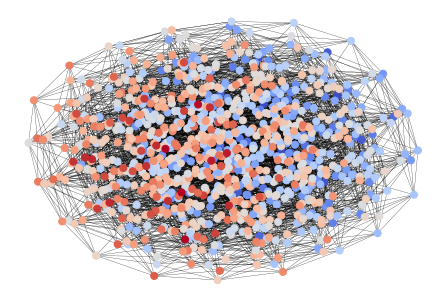

In [280]:
N = 10
hypers = [5,5,5,5,5,1,1,1,1,1]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.9514563106796117
Num of Local Maxima			 4
Mean fitness 0.5005528903251363
S.D. of fitness 0.21168406561105832


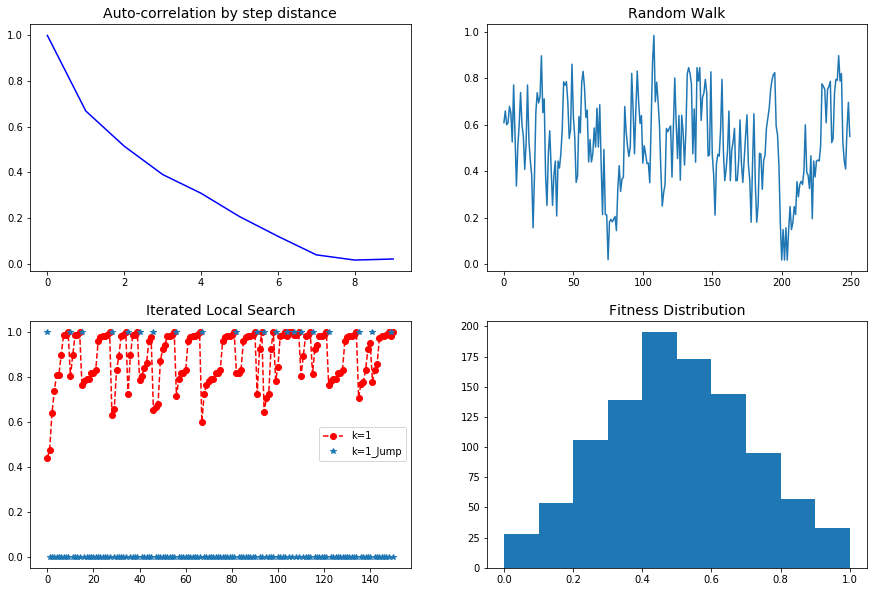

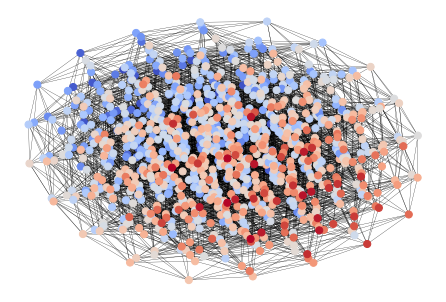

In [281]:
N = 10
hypers = [10,10,10,10,10,1,1,1,1,1]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.9805825242718447
Num of Local Maxima			 61
Mean fitness 0.49480633000800056
S.D. of fitness 0.22238350433237572


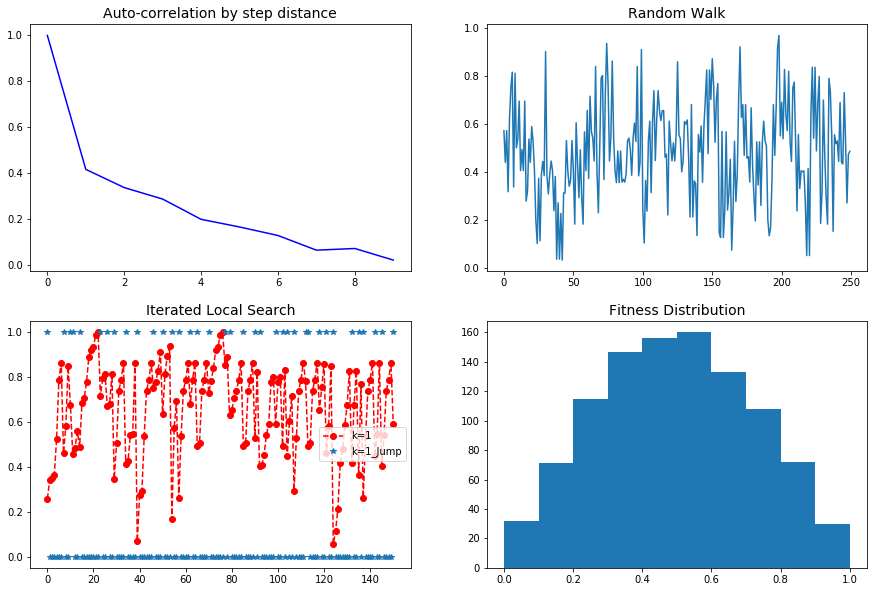

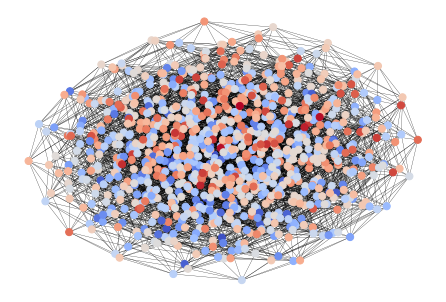

In [282]:
N = 10
hypers = [.9,.9,.9,.9,.9,.9,.9,.9,.9,.9]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 3.087378640776699
Num of Local Maxima			 64
Mean fitness 0.5014293654433603
S.D. of fitness 0.22215378234985353


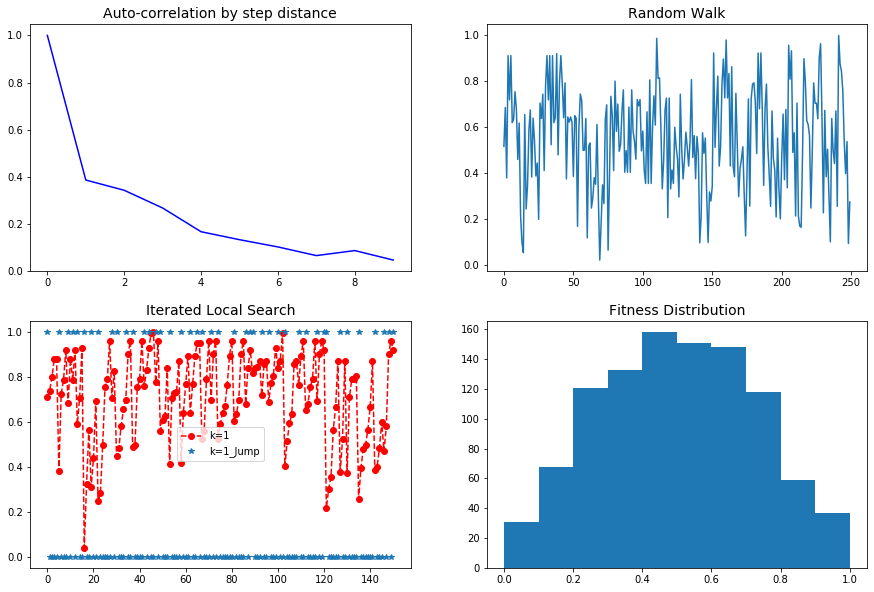

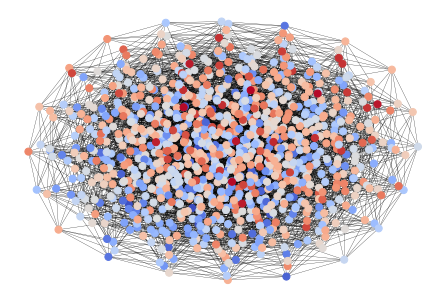

In [283]:
N = 10
hypers = [.75,.75,.75,.75,.75,.75,.75,.75,.75,.75]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 2.9902912621359223
Num of Local Maxima			 60
Mean fitness 0.49892580114460194
S.D. of fitness 0.23894181010773663


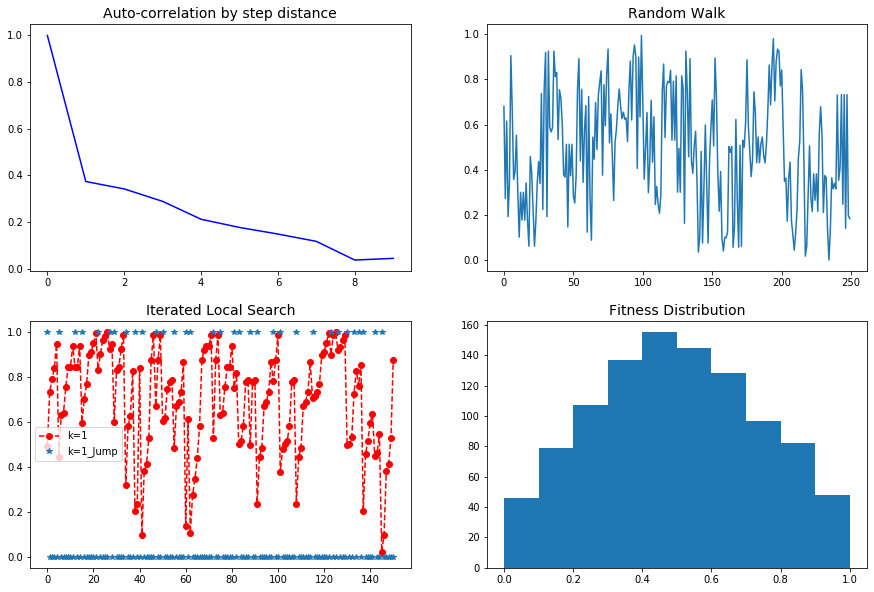

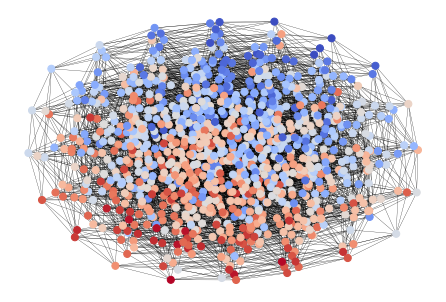

In [285]:
N = 10
hypers = [.65,.65,.65,.65,.65,.65,.65,.65,.65,.65]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 3.4466019417475726
Num of Local Maxima			 76
Mean fitness 0.495730930595376
S.D. of fitness 0.29872166757505153


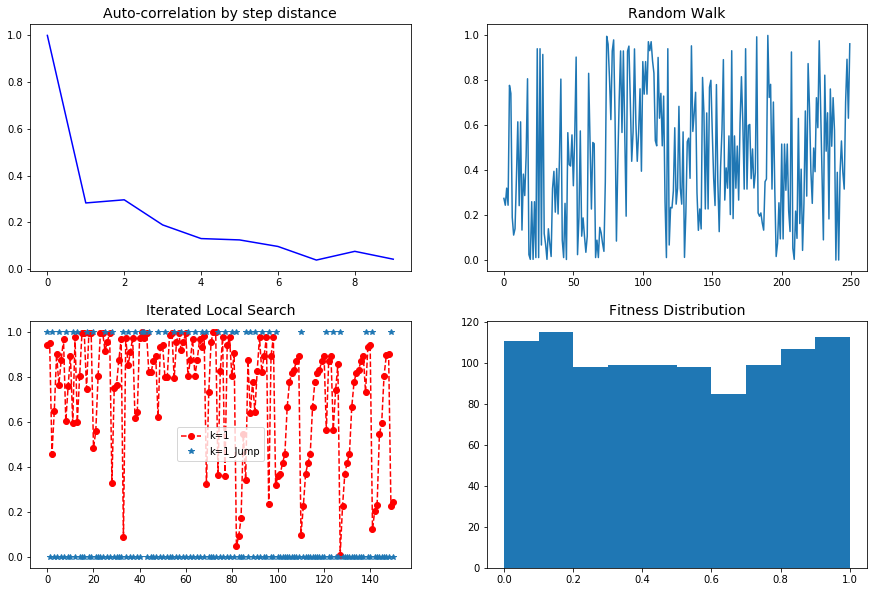

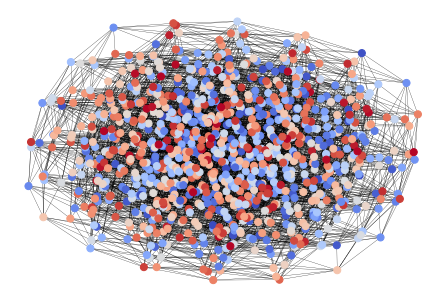

In [287]:
N = 10
hypers = [.25,.25,.25,.25,.25,.25,.25,.25,.25,.25]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)

Avg distance for 90th percentile to Max	 3.1553398058252426
Num of Local Maxima			 64
Mean fitness 0.5019683826338661
S.D. of fitness 0.2557725216456693


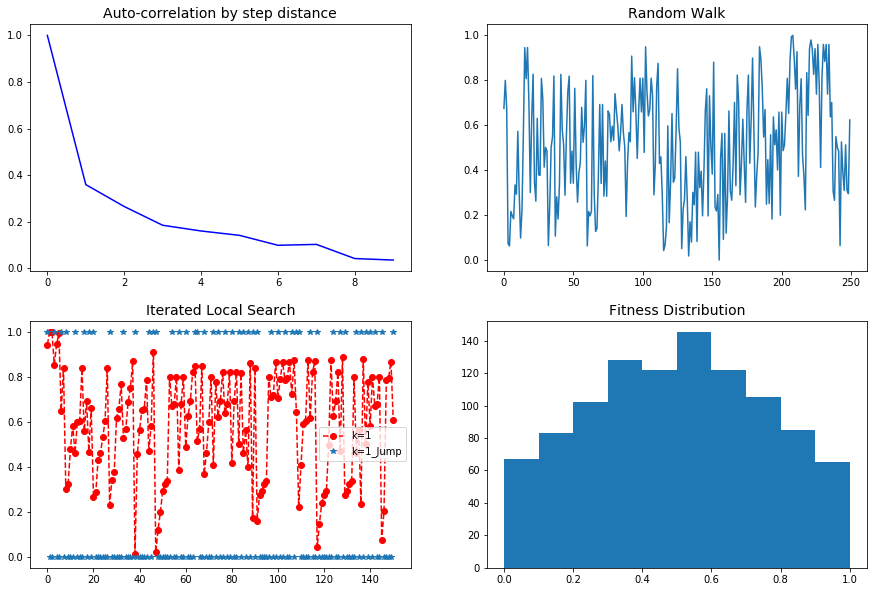

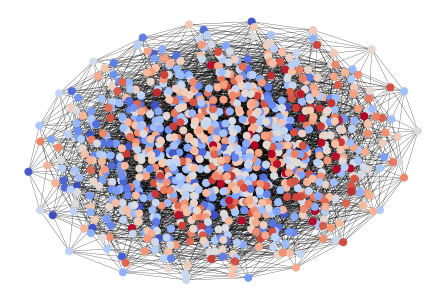

In [291]:
N = 10
hypers = [.25,.25,.65,.65,.95,.95,.65,.65,.25,.25]

Get_Landscape_Summary(create_dotSpace(N,hypers,masked=False),N)